
# LSTM Location Order Prediction Model for Jupyter Notebook
# This notebook uses LSTM to predict the picking order of locations for customer orders

In [30]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.20.0
GPU Available: []


# ==================== STEP 1: Load and Explore Data ====================

In [32]:
print("\n" + "=" * 60)
print("STEP 1: Loading Data")
print("=" * 60)

# Load the CSV file
df = pd.read_csv('./data/paradim ml ranking.csv')

print(f"\nDataset Shape: {df.shape}")
print("\nFirst few rows:")
print(df.head(10))

print("\nData Types:")
print(df.dtypes)

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nUnique Values:")
print(f"Unique Customer Orders: {df['CUST_ORDER_ID'].nunique()}")
print(f"Unique Locations: {df['LOCATION_ID'].nunique()}")
print(f"Location Ranks: {df['LOCATION_RANK'].min()} to {df['LOCATION_RANK'].max()}")


STEP 1: Loading Data

Dataset Shape: (21899, 3)

First few rows:
  CUST_ORDER_ID LOCATION_ID  LOCATION_RANK
0        284986    F7557800              1
1        284986    F7557800              2
2        284986    F6506800              3
3        284986        MISC              4
4      286694-2    E4494800              1
5      286694-2    E4494800              2
6      286694-2    E4494800              3
7      286694-2    E4494800              4
8      286853-2    F4544701              1
9        286895    C4244900              1

Data Types:
CUST_ORDER_ID    object
LOCATION_ID      object
LOCATION_RANK     int64
dtype: object

Basic Statistics:
       LOCATION_RANK
count   21899.000000
mean        8.146445
std        11.392666
min         1.000000
25%         2.000000
50%         4.000000
75%        10.000000
max       125.000000

Missing Values:
CUST_ORDER_ID    0
LOCATION_ID      0
LOCATION_RANK    0
dtype: int64

Unique Values:
Unique Customer Orders: 4774
Unique Locations: 646


# ==================== STEP 2: Data Preparation for LSTM ====================

In [33]:
print("\n" + "=" * 60)
print("STEP 2: Preparing Data for LSTM")
print("=" * 60)

# Encode location IDs
le_location = LabelEncoder()
df['LOCATION_ENCODED'] = le_location.fit_transform(df['LOCATION_ID'])

# Number of unique locations (for embedding layer)
num_locations = len(le_location.classes_)
print(f"\nNumber of unique locations: {num_locations}")

# Sort by customer order and rank to maintain sequence
df = df.sort_values(['CUST_ORDER_ID', 'LOCATION_RANK'])

# Group by customer order to create sequences
order_groups = df.groupby('CUST_ORDER_ID')

print(f"\nTotal orders: {len(order_groups)}")

# Analyze sequence lengths
sequence_lengths = order_groups.size()
print("\nSequence Length Statistics:")
print(sequence_lengths.describe())


STEP 2: Preparing Data for LSTM

Number of unique locations: 646

Total orders: 4774

Sequence Length Statistics:
count    4774.000000
mean        4.587139
std         7.008499
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       125.000000
dtype: float64


# ==================== STEP 3: Create Sequences for LSTM ====================

In [34]:
print("\n" + "=" * 60)
print("STEP 3: Creating Sequences")
print("=" * 60)

# Create sequences of locations and their ranks
sequences = []
targets = []

for order_id, group in order_groups:
    locations = group['LOCATION_ENCODED'].values
    ranks = group['LOCATION_RANK'].values
    
    # Create training samples: use locations to predict their rank
    for i in range(len(locations)):
        # Input: all locations in the order
        seq_input = locations.tolist()
        # Target: the rank of location at position i
        target_rank = ranks[i] - 1  # Convert to 0-indexed
        
        sequences.append((seq_input, i, target_rank))

print(f"Total training samples created: {len(sequences)}")

# Prepare data for LSTM
X_sequences = []
X_positions = []
y_ranks = []

for seq, pos, rank in sequences:
    X_sequences.append(seq)
    X_positions.append(pos)
    y_ranks.append(rank)

# Pad sequences to same length
max_sequence_length = max(len(seq) for seq in X_sequences)
print(f"Maximum sequence length: {max_sequence_length}")

X_sequences_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post')
X_positions = np.array(X_positions)
y_ranks = np.array(y_ranks)

# Determine number of output classes (ranks)
num_ranks = len(np.unique(y_ranks))
print(f"Number of rank classes: {num_ranks}")

# Convert ranks to categorical for classification
y_ranks_categorical = to_categorical(y_ranks, num_classes=num_ranks)

print(f"\nX_sequences shape: {X_sequences_padded.shape}")
print(f"X_positions shape: {X_positions.shape}")
print(f"y_ranks shape: {y_ranks_categorical.shape}")


STEP 3: Creating Sequences
Total training samples created: 21899
Maximum sequence length: 125
Number of rank classes: 125

X_sequences shape: (21899, 125)
X_positions shape: (21899,)
y_ranks shape: (21899, 125)


# ==================== STEP 4: Train-Test Split ====================

In [35]:
print("\n" + "=" * 60)
print("STEP 4: Splitting Data")
print("=" * 60)

X_train, X_test, y_train, y_test = train_test_split(
    X_sequences_padded, y_ranks_categorical, 
    test_size=0.2, 
    random_state=42
)

# Also split positions for additional features
X_train_pos = X_positions[:len(X_train)]
X_test_pos = X_positions[len(X_train):]

print(f"Training Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")


STEP 4: Splitting Data
Training Set: 17519 samples
Test Set: 4380 samples


# ==================== STEP 5: Build LSTM Model ====================

In [36]:
print("\n" + "=" * 60)
print("STEP 5: Building LSTM Model")
print("=" * 60)

def create_lstm_model(vocab_size, max_len, num_classes, embedding_dim=50):
    """
    Create LSTM model for location order prediction
    """
    model = Sequential([
        # Embedding layer to convert location IDs to dense vectors
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
        
        # Bidirectional LSTM to capture patterns in both directions
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.3),
        
        # Second LSTM layer
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.3),
        
        # Dense layers for classification
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
lstm_model = create_lstm_model(
    vocab_size=num_locations + 1,  # +1 for padding
    max_len=max_sequence_length,
    num_classes=num_ranks,
    embedding_dim=50
)

# Compile model
lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'mae']
)

print("\nModel Architecture:")
lstm_model.summary()



STEP 5: Building LSTM Model

Model Architecture:


x:\Projects\Machine Learning\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# ==================== STEP 6: Train LSTM Model ====================

In [ ]:
print("\n" + "=" * 60)
print("STEP 6: Training LSTM Model")
print("=" * 60)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Train model
print("\nTraining started...")
history = lstm_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining completed!")



STEP 6: Training LSTM Model

Training started...
Epoch 1/50
347/438 ━━━━━━━━━━━━━━━━━━━━ 17s 193ms/step - accuracy: 0.1816 - loss: 3.1044 - mae: 0.0140

# ==================== STEP 7: Model Evaluation ====================


STEP 7: Model Evaluation

Test Loss: 2.2152
Test Accuracy: 0.2158
Test MAE: 0.0125

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.70      0.60       965
           1       0.01      0.00      0.00       645
           2       0.20      0.31      0.24       398
           3       0.00      0.00      0.00       326
           4       0.00      0.00      0.00       281
           5       0.12      0.18      0.14       198
           6       0.12      0.16      0.14       176
           7       0.00      0.00      0.00       139
           8       0.08      0.30      0.13       136
           9       0.00      0.00      0.00       121
          10       0.00      0.00      0.00        82
          11       0.00      0.00      0.00        84
          12       0.00      0.00      0.00        75
          13       0.04      0.42      0.07        53
          14       0.00      0.00      0.00        57
          15       0.04    

x:\Projects\Machine Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\Projects\Machine Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\Projects\Machine Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

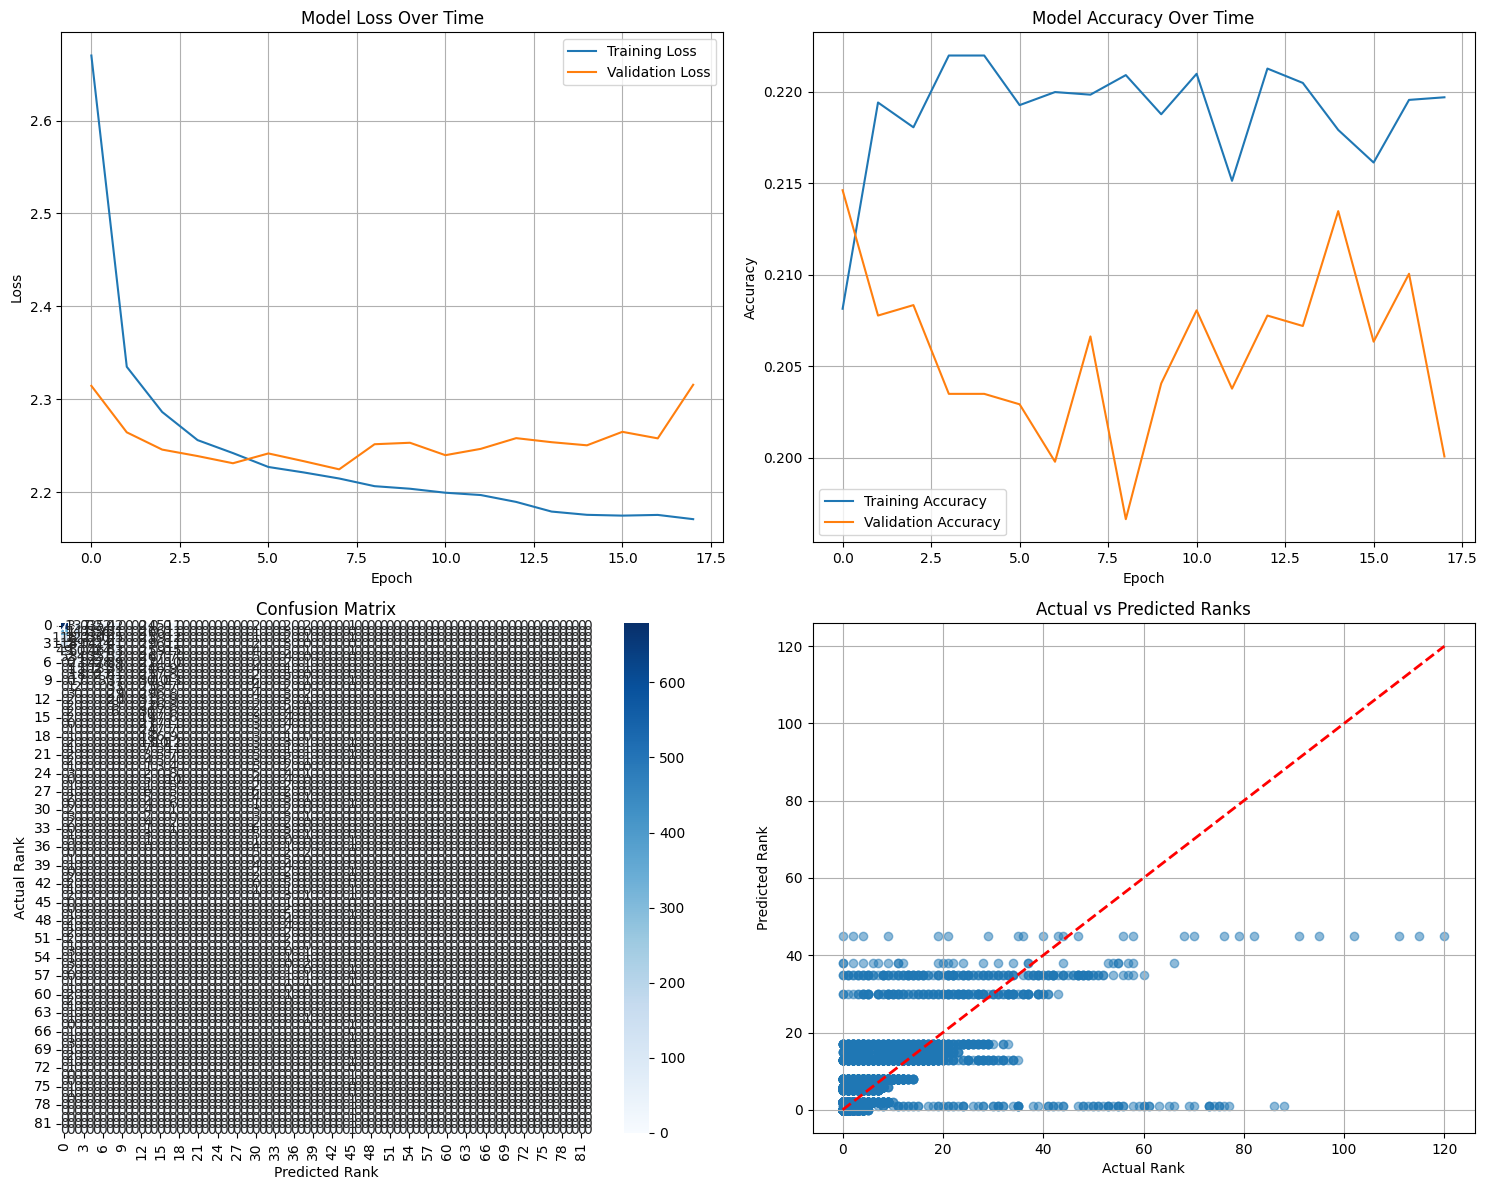


Mean Absolute Error: 4.7872
Accuracy within ±1 rank: 0.4135


In [ ]:
print("\n" + "=" * 60)
print("STEP 7: Model Evaluation")
print("=" * 60)

# Evaluate on test set
test_loss, test_accuracy, test_mae = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Make predictions
y_pred_probs = lstm_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training History - Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Model Loss Over Time')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Training History - Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Model Accuracy Over Time')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted Rank')
axes[1, 0].set_ylabel('Actual Rank')
axes[1, 0].set_title('Confusion Matrix')

# Plot 4: Actual vs Predicted
axes[1, 1].scatter(y_test_labels, y_pred, alpha=0.5)
axes[1, 1].plot([y_test_labels.min(), y_test_labels.max()], 
                [y_test_labels.min(), y_test_labels.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Rank')
axes[1, 1].set_ylabel('Predicted Rank')
axes[1, 1].set_title('Actual vs Predicted Ranks')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Additional metrics
mae = mean_absolute_error(y_test_labels, y_pred)
print(f"\nMean Absolute Error: {mae:.4f}")

# Accuracy within 1 rank
within_1 = np.mean(np.abs(y_test_labels - y_pred) <= 1)
print(f"Accuracy within ±1 rank: {within_1:.4f}")

# ==================== STEP 8: Prediction Function ====================

In [ ]:
print("\n" + "=" * 60)
print("STEP 8: Creating Prediction Function")
print("=" * 60)

def predict_location_order_lstm(location_ids):
    """
    Predict the picking order for a list of location IDs using LSTM
    
    Parameters:
    -----------
    location_ids : list
        List of location IDs for an order
    
    Returns:
    --------
    DataFrame with location IDs and predicted ranks
    """
    # Encode locations
    encoded_locations = []
    unknown_locations = []
    
    for loc_id in location_ids:
        if loc_id in le_location.classes_:
            encoded_locations.append(le_location.transform([loc_id])[0])
        else:
            # Use 0 for unknown locations (padding value)
            encoded_locations.append(0)
            unknown_locations.append(loc_id)
    
    if unknown_locations:
        print(f"Warning: Unknown locations (will use padding): {unknown_locations}")
    
    # Create sequence for each location position
    predictions = []
    sequence = np.array(encoded_locations)
    
    # Pad sequence
    sequence_padded = pad_sequences([sequence], maxlen=max_sequence_length, padding='post')
    
    # Predict for each position in the sequence
    for i, loc_id in enumerate(location_ids):
        # Create input for this position
        input_seq = np.tile(sequence_padded, (1, 1))
        
        # Predict
        pred_probs = lstm_model.predict(input_seq, verbose=0)[0]
        predicted_rank = np.argmax(pred_probs) + 1  # Convert back to 1-indexed
        confidence = pred_probs.max()
        
        predictions.append({
            'LOCATION_ID': loc_id,
            'PREDICTED_RANK': predicted_rank,
            'CONFIDENCE': confidence
        })
    
    # Create result dataframe and sort by predicted rank
    result_df = pd.DataFrame(predictions)
    result_df = result_df.sort_values('PREDICTED_RANK').reset_index(drop=True)
    result_df['SUGGESTED_ORDER'] = range(1, len(result_df) + 1)
    
    return result_df

print("✓ LSTM prediction function created successfully")


STEP 8: Creating Prediction Function
✓ LSTM prediction function created successfully


# ==================== STEP 9: Example Predictions ====================

In [ ]:
print("\n" + "=" * 60)
print("STEP 9: Example Predictions")
print("=" * 60)

# Get a sample order from the original data
sample_order = df[df['CUST_ORDER_ID'] == df['CUST_ORDER_ID'].unique()[0]]
sample_locations = sample_order['LOCATION_ID'].tolist()

print(f"\nSample Order: {sample_order['CUST_ORDER_ID'].iloc[0]}")
print(f"Locations: {sample_locations}")

print("\nActual Order:")
print(sample_order[['LOCATION_ID', 'LOCATION_RANK']].sort_values('LOCATION_RANK'))

print("\nPredicted Order (LSTM):")
predicted_order = predict_location_order_lstm(sample_locations)
print(predicted_order)

# Compare accuracy for this sample
actual_ranks = sample_order.sort_values('LOCATION_ID')['LOCATION_RANK'].values
predicted_ranks = predicted_order.sort_values('LOCATION_ID')['PREDICTED_RANK'].values
sample_mae = mean_absolute_error(actual_ranks, predicted_ranks)
print(f"\nSample MAE: {sample_mae:.4f}")


STEP 9: Example Predictions

Sample Order: 284986
Locations: ['F7557800', 'F7557800', 'F6506800', 'MISC']

Actual Order:
  LOCATION_ID  LOCATION_RANK
0    F7557800              1
1    F7557800              2
2    F6506800              3
3        MISC              4

Predicted Order (LSTM):
  LOCATION_ID  PREDICTED_RANK  CONFIDENCE  SUGGESTED_ORDER
0    F7557800               1    0.283721                1
1    F7557800               1    0.283721                2
2    F6506800               1    0.283721                3
3        MISC               1    0.283721                4

Sample MAE: 1.5000


# ==================== STEP 10: Interactive Prediction ====================

In [ ]:
print("\n" + "=" * 60)
print("STEP 10: Ready for Interactive Predictions")
print("=" * 60)

print("\nTo predict order for new locations, use:")
print("predicted_order = predict_location_order_lstm(['A-101', 'B-205', 'C-310'])")
print("\nExample with random locations:")
test_locations = df['LOCATION_ID'].sample(min(5, len(df))).tolist()
print(f"test_locations = {test_locations}")
result = predict_location_order_lstm(test_locations)
print("\nPredicted picking order:")
print(result)


STEP 10: Ready for Interactive Predictions

To predict order for new locations, use:
predicted_order = predict_location_order_lstm(['A-101', 'B-205', 'C-310'])

Example with random locations:
test_locations = ['B3110000', 'C4254100', 'F7547502', 'C4294800', 'C4294800']

Predicted picking order:
  LOCATION_ID  PREDICTED_RANK  CONFIDENCE  SUGGESTED_ORDER
0    B3110000               1    0.244634                1
1    C4254100               1    0.244634                2
2    F7547502               1    0.244634                3
3    C4294800               1    0.244634                4
4    C4294800               1    0.244634                5


In [ ]:
sf = pd.read_csv('./data/sample.csv')
sample_locations = sf['LOCATION_ID'].tolist()
rf = pd.read_csv('./data/real.csv')
real_locations = rf['LOCATION_ID'].tolist()

result = predict_location_order_lstm(sample_locations);
present = {
    "Predisted Order": result['LOCATION_ID'].tolist(),
    "Real Order": real_locations
}

final = pd.DataFrame(present)
print(final);

   Predisted Order Real Order
0         D5000000   C4000000
1         E4000000   E4000000
2         F8508200   D5000000
3         C4000000   D5000000
4         D4000000   F8508200
5         F4000000   D4000000
6         D4000000   E4000000
7         E4000000   D4000000
8         D4000000   F4000000
9         F5000000   F4000000
10        F4000000   D4000000
11        D8348400   F4000000
12        G8648100   D8348400
13        D8308800   F5000000
14        D6000000   G8608200
15        G8608200   G8648100
16        D5000000   D8308800
17        D5000000   D6000000


# ==================== STEP 11: Model Saving ====================

In [ ]:
print("\n" + "=" * 60)
print("STEP 11: Saving Model")
print("=" * 60)

# Save the model
lstm_model.save('./models/location_order_lstm_model.h5')
print("✓ Model saved as 'location_order_lstm_model.h5'")

# Save label encoder
import pickle       
with open('./models/location_encoder.pkl', 'wb') as f:
    pickle.dump(le_location, f)
print("✓ Label encoder saved as 'location_encoder.pkl'")

print("\n" + "=" * 60)
print("LSTM MODEL TRAINING COMPLETE!")
print("=" * 60)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Accuracy within ±1 rank: {within_1:.4f}")
print("Ready to predict location orders for new customer orders")
print("=" * 60)


STEP 11: Saving Model
✓ Model saved as 'location_order_lstm_model.h5'
✓ Label encoder saved as 'location_encoder.pkl'

LSTM MODEL TRAINING COMPLETE!
Test Accuracy: 0.2158
Test MAE: 0.0125
Accuracy within ±1 rank: 0.4135
Ready to predict location orders for new customer orders


In [ ]:
model = keras.models.load_model('./models/location_order_lstm_model.h5', compile=False)
sf = pd.read_csv('./data/sample.csv')
sample_locations = sf['LOCATION_ID'].tolist()

model.summary()

    # Encode locations
encoded_locations = []
unknown_locations = []

for loc_id in sample_locations:
    if loc_id in le_location.classes_:
        encoded_locations.append(le_location.transform([loc_id])[0])
    else:
        # Use 0 for unknown locations (padding value)
        encoded_locations.append(0)
        unknown_locations.append(loc_id)

if unknown_locations:
    print(f"Warning: Unknown locations (will use padding): {unknown_locations}")

# Create sequence for each location position
predictions = []
sequence = np.array(encoded_locations)

# Pad sequence
sequence_padded = pad_sequences([sequence], maxlen=max_sequence_length, padding='post')

# Predict for each position in the sequence
for i, loc_id in enumerate(sample_locations):
    # Create input for this position
    input_seq = np.tile(sequence_padded, (1, 1))
    
    # Predict
    pred_probs = model.predict(input_seq, verbose=0)[0]
    predicted_rank = np.argmax(pred_probs) + 1  # Convert back to 1-indexed
    confidence = pred_probs.max()
    
    predictions.append({
        'LOCATION_ID': loc_id,
        'PREDICTED_RANK': predicted_rank,
        'CONFIDENCE': confidence
    })

# Create result dataframe and sort by predicted rank
result_df = pd.DataFrame(predictions)
result_df = result_df.sort_values('PREDICTED_RANK').reset_index(drop=True)
result_df['SUGGESTED_ORDER'] = range(1, len(result_df) + 1)

print(result_df);

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 125, 50)        │        32,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 125, 256)       │       183,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 125, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 125)            │         8,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,891 (1.58 MB)

 Trainable params: 412,891 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

   LOCATION_ID  PREDICTED_RANK  CONFIDENCE  SUGGESTED_ORDER
0     D5000000               1    0.999523                1
1     E4000000               1    0.999523                2
2     F8508200               1    0.999523                3
3     C4000000               1    0.999523                4
4     D4000000               1    0.999523                5
5     F4000000               1    0.999523                6
6     D4000000               1    0.999523                7
7     E4000000               1    0.999523                8
8     D4000000               1    0.999523                9
9     F5000000               1    0.999523               10
10    F4000000               1    0.999523               11
11    D8348400               1    0.999523               12
12    G8648100               1    0.999523               13
13    D8308800               1    0.999523               14
14    D6000000               1    0.999523               15
15    G8608200               1    0.9995

In [ ]:
def predict_location_order_lstm(location_ids):
    """
    Predict the picking order for a list of location IDs using LSTM
    
    Parameters:
    -----------
    location_ids : list
        List of location IDs for an order
    
    Returns:
    --------
    DataFrame with location IDs and predicted ranks
    """
    model = keras.models.load_model('./models/location_order_lstm_model.h5', compile=False)

    with open('./models/location_encoder.pkl', 'rb') as f:
        le_location = pickle.load(f)

    # Encode locations
    encoded_locations = []
    unknown_locations = []
    
    for loc_id in location_ids:
        if loc_id in le_location.classes_:
            encoded_locations.append(le_location.transform([loc_id])[0])
        else:
            # Use 0 for unknown locations (padding value)
            encoded_locations.append(0)
            unknown_locations.append(loc_id)
    
    if unknown_locations:
        print(f"Warning: Unknown locations (will use padding): {unknown_locations}")
    
    # Create sequence for each location position
    predictions = []
    sequence = np.array(encoded_locations)
    max_sequence_length = max(len(seq) for seq in location_ids)

    # Pad sequence
    sequence_padded = pad_sequences([sequence], maxlen=max_sequence_length, padding='post')
    
    # Predict for each position in the sequence
    for i, loc_id in enumerate(location_ids):
        # Create input for this position
        input_seq = np.tile(sequence_padded, (1, 1))
        
        # Predict
        pred_probs = model.predict(input_seq, verbose=0)[0]
        predicted_rank = np.argmax(pred_probs) + 1  # Convert back to 1-indexed
        confidence = pred_probs.max()
        
        predictions.append({
            'LOCATION_ID': loc_id,
            'PREDICTED_RANK': predicted_rank,
            'CONFIDENCE': confidence
        })
    
    # Create result dataframe and sort by predicted rank
    result_df = pd.DataFrame(predictions)
    result_df = result_df.sort_values('PREDICTED_RANK').reset_index(drop=True)
    result_df['SUGGESTED_ORDER'] = range(1, len(result_df) + 1)
    
    return result_df

print("First Model Predictions:")
print(predict_location_order_lstm(input_seq))
input_seq = ['D5000000', 'E4000000', 'F8508200']


First Model Predictions:


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'location_order_lstm_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)